# Notebook Setup

In [2]:
if 'google.colab' in str(get_ipython()):
    IN_COLLAB = True
else:
    IN_COLLAB = False

if IN_COLLAB:
    #TODO: CHANGE THIS BASED ON YOUR OWN LOCAL SETTINGS
    MY_HOME_ABS_PATH = "/content/drive/MyDrive/W210/co2-flux-hourly-gpp-modeling"
    # MY_HOME_ABS_PATH = "/content/drive/MyDrive/TFT_baseline"
    from google.colab import drive
    drive.mount('/content/drive/')
else:
    MY_HOME_ABS_PATH = "/root/co2-flux-hourly-gpp-modeling/"
    # MY_HOME_ABS_PATH = "/home/ec2-user/SageMaker/root/co2-flux-hourly-gpp-modeling"

## Import Modules

In [3]:
if IN_COLLAB:
    !pip install torch pytorch-lightning pytorch_forecasting azure-storage-blob -q
else:
    !pip install xgboost -q

In [4]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")
import copy
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print(xgboost.__version__)

from timeit import default_timer
from datetime import datetime
import gc
import pickle
import random
from pprint import pprint

# Load locale custome modules
os.chdir(MY_HOME_ABS_PATH)
if IN_COLLAB:
     os.environ["MY_HOME_ABS_PATH"] = MY_HOME_ABS_PATH
     sys.path.insert(0,os.path.abspath("./code/src/tools"))
else:
    sys.path.append('./cred')
    sys.path.append('./code/src/tools')
    sys.path.append(os.path.abspath("./code/src/tools"))

from CloudIO.AzStorageClient import AzStorageClient
from data_pipeline_lib import *
from model_pipeline_lib import *

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pl.seed_everything(42)

1.7.5


2023-04-08 19:04:08.332258: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-08 19:04:08.334560: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-08 19:04:08.383773: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-08 19:04:08.384549: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-08 19:04:09.219860: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

42

# Setup Experiments

## Define Local File System Constants

In [5]:
root_dir  = MY_HOME_ABS_PATH
tmp_dir   = root_dir + os.sep + '.tmp'
model_dir = root_dir + os.sep + 'data' + os.sep + 'models'
PREPRO_DIR = root_dir + "/code/src/preprocessing/preproc_objects"

container = "all-sites-data"
blob_name = "full_2010_2015_v_mvp_raw.parquet"
local_file = tmp_dir + os.sep + blob_name

## Define Features and Target

In [6]:
target_variable = 'GPP_NT_VUT_REF'

categorical_cols = ['month', 'day', 'hour', 'koppen_sub', 'koppen_main', 'MODIS_PFT', 'MODIS_IGBP', 'MODIS_LC']
realNum_cols = ['TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA', 
                'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7',
                'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily',
                'PET', 'Ts', 'ESACCI-sm', 'NDWI', 'Percent_Snow', 'Fpar', 'Lai',
                'LST_Day', 'LST_Night']
features = categorical_cols + realNum_cols

supplement_cols= ['site_id', 'timestep_idx_local','gap_flag_hour','gap_flag_month',]

## Define Helper Functions


In [7]:
class X_y_set:
    X = None
    y = None

def normalize_real_cols(foldNo, realNum_cols, train_X, val_X, test_X = None):

    # Normalize data
    print(f"Normalizing real features ({len(realNum_cols)})")
    scaler = StandardScaler().fit(train_X[realNum_cols])
    train_X.loc[:,realNum_cols] = scaler.transform(train_X[realNum_cols])
    val_X.loc[:,realNum_cols] = scaler.transform(val_df[realNum_cols])

    # Save scaler object
    scaler_path = os.path.join(PREPRO_DIR, f'scaler_cv{foldNo}.joblib')
    joblib.dump(scaler, scaler_path)
    print(f"Saved scaler to {scaler_path}.")
      
    train_X.reset_index(inplace=True, drop=True)
    val_X.reset_index(inplace=True, drop=True)
    print(f"Train data size: {train_X.shape}.")
    print(f"Val data size: {val_X.shape}.")

    if test_X is not None:
        test_X.loc[:,realNum_cols] = scaler.transform(test_X[realNum_cols]) 
        test_X.reset_index(inplace=True, drop=True)
        print(f"Test data size: {test_X.shape}.") 
  
    return train_X, val_X, test_X

def split_to_X_y(df):
    dataset = X_y_set()
    dataset.X = df.drop([target_variable] + supplement_cols, axis=1)
    dataset.y = df[target_variable]                
    return dataset

def RunXGBoostCV(params, fold_data, exp_dir, debug=False, features=None):
    cv_results_df = pd.DataFrame(columns=['Fold_No', 'RMSE', 'MAE', 'R2', 'LOSS_SD', 'filename'])
    for i, cv in enumerate(fold_data):
        verbose = 0
        if debug:
            print(f"Fold {i+1}:")
            verbose = 1

        train = cv['train']
        val = cv['val']
        model = XGBRegressor(**best_params, random_state=42,
                             tree_method="approx", enable_categorical=True,
                             importance_type='gain',
                             n_jobs=-1, verbosity=verbose) # <--- Update this model!
        
        # Trim features is necessary
        if features is not None:
            train_X = train.X[features] 
            val_X = val.X[features]
        else:
            train_X = train.X
            val_X = val.X
        
        model.fit(train_X, train.y)

        # Evaluate model
        val_actuals = val.y
        val_pred = model.predict(val_X)
        rmse = np.sqrt(mean_squared_error(val_actuals, val_pred))
        mae = mean_absolute_error(val_actuals, val_pred)
        r2 = r2_score(val_actuals, val_pred)
        loss_std = np.std(val_actuals - val_pred)
        if debug:
            print(f"  Val RMSE: {rmse}, Val MAE: {mae}, Val R2/NSE: {r2}, val Loss SD: {loss_std}")

        # # Save models
        filesname = f"model_cv{i+1}.pkl"
        pickle.dump(model, open( exp_dir + os.sep + filesname, 'wb'))
        print(f"  save model to {exp_dir + os.sep + filesname}.")
        result = {'Fold_No': int(i+1), 'RMSE':rmse, 'MAE':mae, 'R2':r2 , 'LOSS_SD':loss_std, 'filename': filesname}
        cv_results_df = cv_results_df.append(result, ignore_index=True)

    print(f"Results from params {best_params}:") 
    display(cv_results_df)
    display(cv_results_df[['RMSE', 'MAE', 'R2']].mean(axis=0))

    # Save CV result of CSV
    cv_results_df.to_csv(exp_dir + os.sep + "cv_result.csv", index=False)
    print(f"CV results saved to {exp_dir + os.sep + 'cv_result.csv'}")

def feature_importance(model, model_name, columns, fig_num, fig, ax):
    # get the feature importances
    importances = pd.Series(model.feature_importances_, index=columns)#.sort_values(ascending=False)
    # Visualize
    importances_sorted = importances.sort_values(ascending=True)[-30:]

    ax[fig_num].barh(importances_sorted.index, importances_sorted.values)
    ax[fig_num].set_title(model_name + '  Feature Importances')
    ax[fig_num].set_xlabel('Importance')
    ax[fig_num].set_ylabel('Feature')
    return importances

# Load data from Azure Blob

In [8]:
data_df = get_raw_datasets(container, blob_name)
# data_df = data_df.loc[data_df['timestep_idx_local'] < 24*180, ].copy() # TODO: remove
data_df = data_df[[target_variable] + features + supplement_cols]
print(f"\nData size: {data_df.shape}")

# Drop gap flag hour = 1
data_df[data_df["gap_flag_hour"] == float(0)].reset_index(drop=True)
print(f"\nDrop gap-filled (hour) - Data size: {data_df.shape}")

# Encode categorical variables <-- TODO: Change to Dummy for RFR
# ref: https://xgboost.readthedocs.io/en/stable/tutorials/categorical.html
for col in categorical_cols:
    data_df[col] = data_df[col].astype('category')

print(f"\nData size: {data_df.shape}")
print(data_df.columns)

Data size: (4862712, 51)
Data Columns: Index(['GPP_NT_VUT_REF', 'site_id', 'timestep_idx_local',
       'timestep_idx_global', 'datetime', 'date', 'year', 'month', 'day',
       'hour', 'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA',
       'PA_ERA', 'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6',
       'b7', 'IGBP', 'lat', 'long', 'koppen_sub', 'koppen_main', 'c3c4',
       'c4_percent', 'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily',
       'PET', 'Ts', 'ESACCI-sm', 'MODIS_LC', 'NDWI', 'Percent_Snow', 'Fpar',
       'Lai', 'LST_Day', 'LST_Night', 'MODIS_IGBP', 'MODIS_PFT',
       'gap_flag_hour', 'gap_flag_month'],
      dtype='object')
NA count: 0

Data size: (4862712, 42)

Drop gap-filled (hour) - Data size: (4862712, 42)

Data size: (4862712, 42)
Index(['GPP_NT_VUT_REF', 'month', 'day', 'hour', 'koppen_sub', 'koppen_main',
       'MODIS_PFT', 'MODIS_IGBP', 'MODIS_LC', 'TA_ERA', 'SW_IN_ERA',
       'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA', 'EVI', 'NDV

# Create CV dataset

In [9]:
TEST_INDEX = 4
fold_data = []
for i in range(4):
    print(f"\nFold {i+1}:")
    train_df, val_df, _ = get_splited_datasets(data_df, i, TEST_INDEX)

    train = split_to_X_y(train_df)
    val   = split_to_X_y(val_df)
    train.X, val.X, _ = normalize_real_cols(int(i+1), realNum_cols, train.X, val.X, None)

    print(f"train_y({train.y.shape}), train_X({train.X.shape})")
    print(f"val_y({val.y.shape}), val_X({val.X.shape})")
    fold_data.append({"train": train, "val": val})


Fold 1:
Normalizing real features (29)
Saved scaler to /root/co2-flux-hourly-gpp-modeling/code/src/preprocessing/preproc_objects/scaler_cv1.joblib.
Train data size: (2997048, 37).
Val data size: (883296, 37).
train_y((2997048,)), train_X((2997048, 37))
val_y((883296,)), val_X((883296, 37))

Fold 2:
Normalizing real features (29)
Saved scaler to /root/co2-flux-hourly-gpp-modeling/code/src/preprocessing/preproc_objects/scaler_cv2.joblib.
Train data size: (2924472, 37).
Val data size: (955872, 37).
train_y((2924472,)), train_X((2924472, 37))
val_y((955872,)), val_X((955872, 37))

Fold 3:
Normalizing real features (29)
Saved scaler to /root/co2-flux-hourly-gpp-modeling/code/src/preprocessing/preproc_objects/scaler_cv3.joblib.
Train data size: (2895240, 37).
Val data size: (985104, 37).
train_y((2895240,)), train_X((2895240, 37))
val_y((985104,)), val_X((985104, 37))

Fold 4:
Normalizing real features (29)
Saved scaler to /root/co2-flux-hourly-gpp-modeling/code/src/preprocessing/preproc_ob

# Cross Validation with Default XGBoost Params

In [37]:
# Create model result directory
#experiment_ts = datetime.now().strftime("%y%m%d_%H%M")
experiment_ts = "default"
exp_dir = model_dir + os.sep + f"xgboost_{experiment_ts}" 
if not (os.path.exists(exp_dir)):
    os.makedirs(exp_dir)
print(f"Experiment logs saved to {exp_dir}.")
  
best_params = {}
cv_results = RunXGBoostCV(best_params, fold_data, exp_dir)

Experiment logs saved to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_default.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_default/model_cv1.pkl.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_default/model_cv2.pkl.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_default/model_cv3.pkl.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_default/model_cv4.pkl.
Results from params {}:


,Fold_No,RMSE,MAE,R2,LOSS_SD,filename
0,1,3.76068,2.03979,0.70028,3.75155,model_cv1.pkl
1,2,4.14985,2.21658,0.59414,4.10937,model_cv2.pkl
2,3,3.89046,2.11998,0.70688,3.88755,model_cv3.pkl
3,4,3.67020,2.10170,0.73413,3.66826,model_cv4.pkl


RMSE   3.86780
MAE    2.11951
R2     0.68386
dtype: float64

CV results saved to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_default/cv_result.csv


## Compare Feature Importances

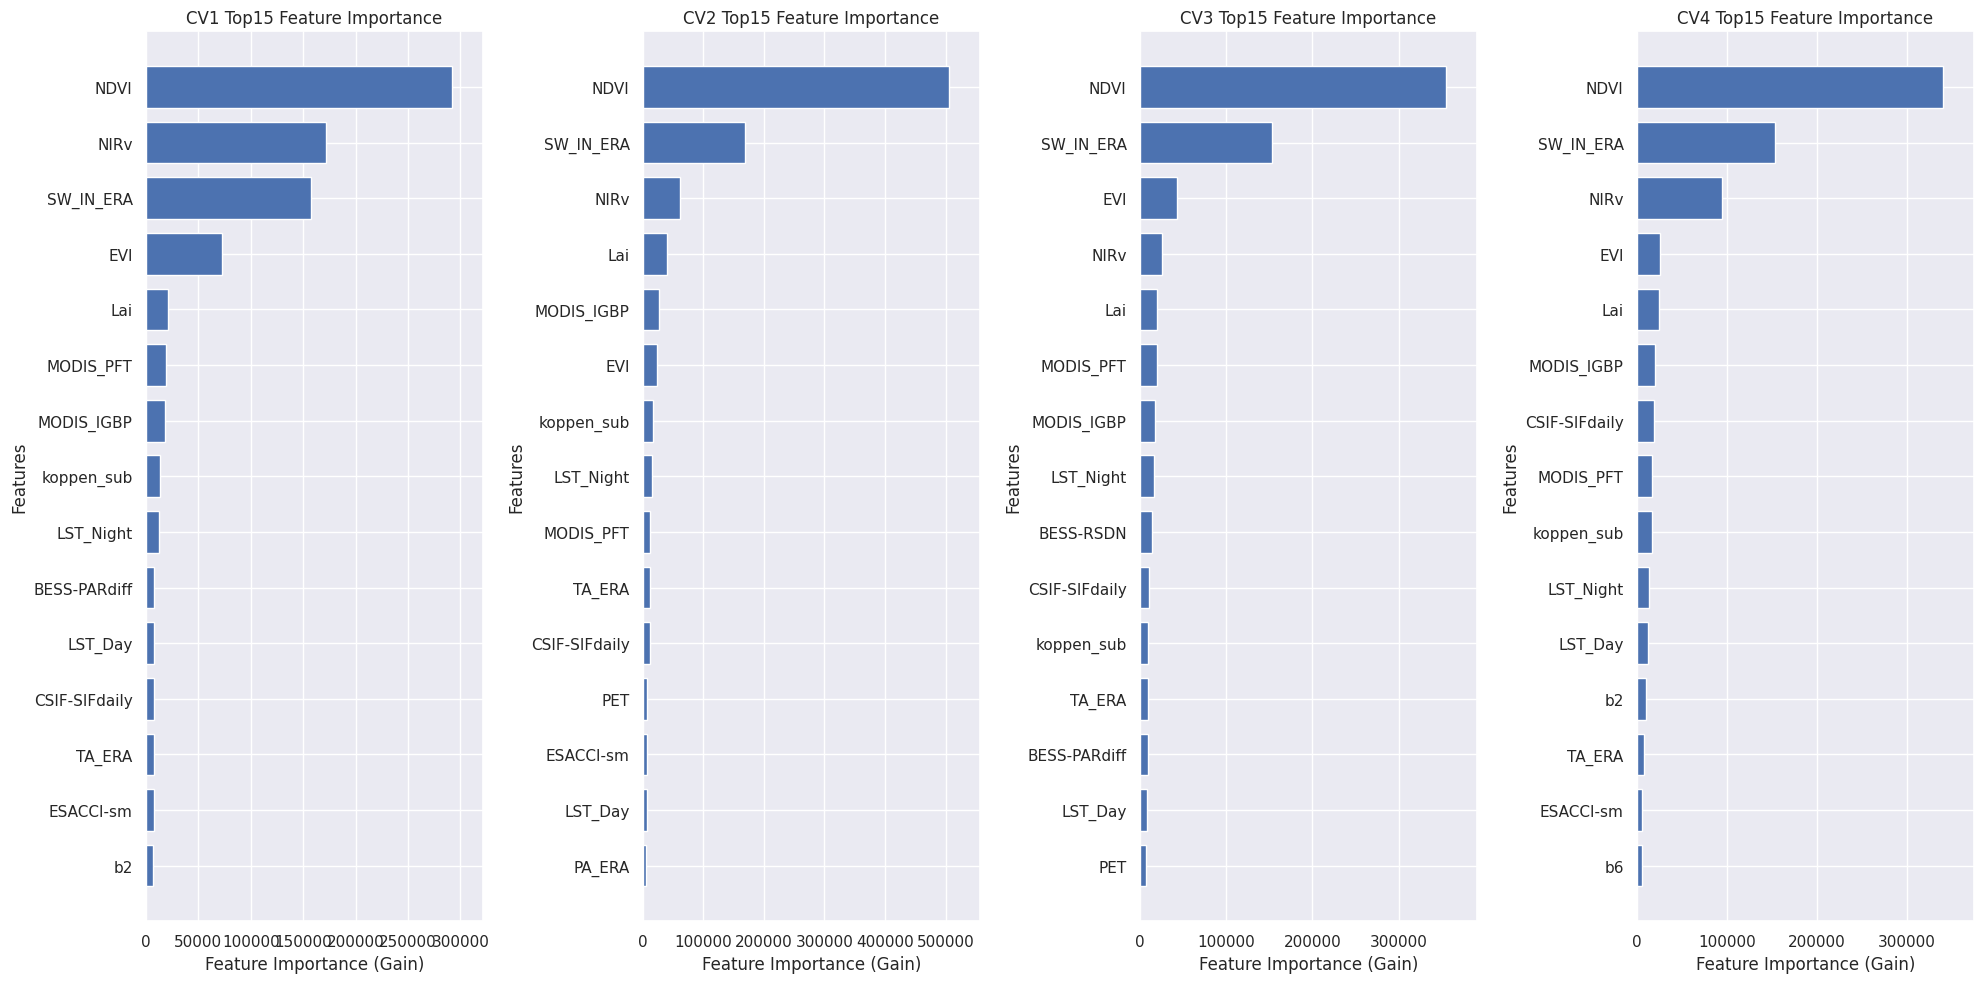

CV importance saved to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_default/cv_importance.csv


In [19]:
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(30,10), })
fig, ax = plt.subplots(1, 4, figsize=(20,10))

# Get CV result
exp_dir = root_dir + "/data/models/xgboost_default"
cv_results_df = pd.read_csv(exp_dir + os.sep + "cv_result.csv")

#ref: https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7
cv_importances_df = pd.DataFrame()
for i, cv in cv_results_df.iterrows():
    modelpath = exp_dir + os.sep + cv.filename
    model = pickle.load(open(modelpath, 'rb'))
    plot_importance(model, ax=ax[i], 
                    title=f"CV{cv.Fold_No} Top15 Feature Importance", xlabel="Feature Importance (Gain)",
                    height=0.75, importance_type='gain', max_num_features=15,
                    show_values=False)
    cv_importances = pd.Series(model.feature_importances_, index=model.feature_names_in_)
    cv_importances_df[f"cv{cv.Fold_No}"] = cv_importances

fig.tight_layout()
plt.show()
cv_importances_df = cv_importances_df.reset_index()
cv_importances_df.columns = ['feature_name','cv1', 'cv2', 'cv3', 'cv4']

# Save CV Importance of CSV
cv_importances_df.to_csv(exp_dir + os.sep + "cv_importance.csv", index=False)
print(f"CV importance saved to {exp_dir + os.sep + 'cv_importance.csv'}")

# Dimensionality Reduction + CV

In [16]:
# Create model result directory
experiment_ts = "trim5"
exp_dir = model_dir + os.sep + f"xgboost_{experiment_ts}" 
if not (os.path.exists(exp_dir)):
    os.makedirs(exp_dir)
print(f"Experiment logs saved to {exp_dir}.")
  
best_params = {}
subset_features = ['NDVI', 'NIRv', 'SW_IN_ERA', 'Lai', 'EVI', ]
cv_results = RunXGBoostCV(best_params, fold_data, exp_dir, False, subset_features)

Experiment logs saved to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_trim5.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_trim5/model_cv1.pkl.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_trim5/model_cv2.pkl.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_trim5/model_cv3.pkl.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_trim5/model_cv4.pkl.
Results from params {}:


,Fold_No,RMSE,MAE,R2,LOSS_SD,filename
0,1,3.70144,1.99248,0.70965,3.69583,model_cv1.pkl
1,2,3.95066,2.04155,0.63217,3.92777,model_cv2.pkl
2,3,3.97872,2.10709,0.69343,3.96668,model_cv3.pkl
3,4,3.72166,2.09194,0.72663,3.72137,model_cv4.pkl


RMSE   3.83812
MAE    2.05826
R2     0.69047
dtype: float64

CV results saved to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_trim5/cv_result.csv


In [13]:
# Create model result directory
experiment_ts = "trim4"
exp_dir = model_dir + os.sep + f"xgboost_{experiment_ts}" 
if not (os.path.exists(exp_dir)):
    os.makedirs(exp_dir)
print(f"Experiment logs saved to {exp_dir}.")
  
best_params = {}
subset_features = ['NDVI', 'NIRv', 'SW_IN_ERA', 'EVI', ]
cv_results = RunXGBoostCV(best_params, fold_data, exp_dir, False, subset_features)

Experiment logs saved to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_trim4.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_trim4/model_cv1.pkl.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_trim4/model_cv2.pkl.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_trim4/model_cv3.pkl.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_trim4/model_cv4.pkl.
Results from params {}:


,Fold_No,RMSE,MAE,R2,LOSS_SD,filename
0,1,3.73759,2.01071,0.70395,3.73537,model_cv1.pkl
1,2,3.91869,2.02165,0.63810,3.89695,model_cv2.pkl
2,3,3.94263,2.09681,0.69897,3.93385,model_cv3.pkl
3,4,3.63148,2.03381,0.73971,3.63134,model_cv4.pkl


RMSE   3.80760
MAE    2.04075
R2     0.69518
dtype: float64

CV results saved to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_trim4/cv_result.csv


In [15]:
#Create model result directory
experiment_ts = "trim3"
exp_dir = model_dir + os.sep + f"xgboost_{experiment_ts}" 
if not (os.path.exists(exp_dir)):
    os.makedirs(exp_dir)
print(f"Experiment logs saved to {exp_dir}.")
  
best_params = {}
subset_features = ['NDVI', 'NIRv', 'SW_IN_ERA',]
cv_results = RunXGBoostCV(best_params, fold_data, exp_dir, False, subset_features)

Experiment logs saved to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_trim3.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_trim3/model_cv1.pkl.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_trim3/model_cv2.pkl.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_trim3/model_cv3.pkl.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_trim3/model_cv4.pkl.
Results from params {}:


,Fold_No,RMSE,MAE,R2,LOSS_SD,filename
0,1,3.72162,1.99960,0.70648,3.71946,model_cv1.pkl
1,2,3.91915,2.01007,0.63801,3.90134,model_cv2.pkl
2,3,3.93831,2.09451,0.69963,3.93069,model_cv3.pkl
3,4,3.63370,2.03046,0.73939,3.63363,model_cv4.pkl


RMSE   3.80320
MAE    2.03366
R2     0.69588
dtype: float64

CV results saved to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_trim3/cv_result.csv


# Random Search CV

In [10]:
del data_df
gc.collect()

0

In [14]:
# Create model result directory
exp_root_dir = model_dir + os.sep + "xgboost_tuned" 
print(f"Experiment logs saved to {exp_root_dir}.")

subset_features = ['NDVI', 'NIRv', 'SW_IN_ERA',]

# Run Randome Search
n = 10
for i in range(n):
    # create model dir
    exp_dir = exp_root_dir + os.sep + f"exp_{i+1}"
    if not (os.path.exists(exp_dir)):
        os.makedirs(exp_dir)
    print(f"\nExperiment {i+1} saved to {exp_dir}.")

    best_params = {}
    best_params['n_estimators'] = 5*random.randint(1, 26)
    best_params['max_depth'] = 5*random.randint(1, 6)
    print(best_params)
    cv_results = RunXGBoostCV(best_params, fold_data, exp_dir, False, subset_features)

Experiment logs saved to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned.

Experiment 1 saved to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_1.
{'n_estimators': 40, 'max_depth': 20}
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_1/model_cv1.pkl.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_1/model_cv2.pkl.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_1/model_cv3.pkl.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_1/model_cv4.pkl.
Results from params {'n_estimators': 40, 'max_depth': 20}:


,Fold_No,RMSE,MAE,R2,LOSS_SD,filename
0,1,4.23616,2.31735,0.61970,4.23185,model_cv1.pkl
1,2,4.41369,2.31520,0.54089,4.40000,model_cv2.pkl
2,3,4.45328,2.41993,0.61594,4.44737,model_cv3.pkl
3,4,4.26947,2.38150,0.64022,4.26947,model_cv4.pkl


RMSE   4.34315
MAE    2.35850
R2     0.60419
dtype: float64

CV results saved to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_1/cv_result.csv

Experiment 2 saved to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_2.
{'n_estimators': 95, 'max_depth': 15}
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_2/model_cv1.pkl.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_2/model_cv2.pkl.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_2/model_cv3.pkl.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_2/model_cv4.pkl.
Results from params {'n_estimators': 95, 'max_depth': 15}:


,Fold_No,RMSE,MAE,R2,LOSS_SD,filename
0,1,4.05190,2.17992,0.65207,4.04832,model_cv1.pkl
1,2,4.24413,2.19434,0.57549,4.22589,model_cv2.pkl
2,3,4.25609,2.27501,0.64920,4.24952,model_cv3.pkl
3,4,4.06928,2.25762,0.67317,4.06909,model_cv4.pkl


RMSE   4.15535
MAE    2.22672
R2     0.63748
dtype: float64

CV results saved to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_2/cv_result.csv

Experiment 3 saved to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_3.
{'n_estimators': 130, 'max_depth': 5}
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_3/model_cv1.pkl.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_3/model_cv2.pkl.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_3/model_cv3.pkl.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_3/model_cv4.pkl.
Results from params {'n_estimators': 130, 'max_depth': 5}:


,Fold_No,RMSE,MAE,R2,LOSS_SD,filename
0,1,3.71075,1.99751,0.70819,3.70831,model_cv1.pkl
1,2,3.91150,2.00606,0.63942,3.89329,model_cv2.pkl
2,3,3.92384,2.08745,0.70183,3.91598,model_cv3.pkl
3,4,3.61616,2.01827,0.74190,3.61614,model_cv4.pkl


RMSE   3.79056
MAE    2.02732
R2     0.69784
dtype: float64

CV results saved to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_3/cv_result.csv

Experiment 4 saved to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_4.
{'n_estimators': 125, 'max_depth': 10}
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_4/model_cv1.pkl.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_4/model_cv2.pkl.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_4/model_cv3.pkl.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_4/model_cv4.pkl.
Results from params {'n_estimators': 125, 'max_depth': 10}:


,Fold_No,RMSE,MAE,R2,LOSS_SD,filename
0,1,3.84092,2.06410,0.68736,3.83823,model_cv1.pkl
1,2,4.04432,2.08137,0.61452,4.02524,model_cv2.pkl
2,3,4.06136,2.15897,0.68057,4.05401,model_cv3.pkl
3,4,3.78838,2.11430,0.71674,3.78830,model_cv4.pkl


RMSE   3.93375
MAE    2.10469
R2     0.67479
dtype: float64

CV results saved to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_4/cv_result.csv

Experiment 5 saved to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_5.
{'n_estimators': 115, 'max_depth': 20}
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_5/model_cv1.pkl.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_5/model_cv2.pkl.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_5/model_cv3.pkl.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_5/model_cv4.pkl.
Results from params {'n_estimators': 115, 'max_depth': 20}:


,Fold_No,RMSE,MAE,R2,LOSS_SD,filename
0,1,4.34875,2.39044,0.59922,4.34464,model_cv1.pkl
1,2,4.54943,2.39007,0.51222,4.53664,model_cv2.pkl
2,3,4.56899,2.48752,0.59572,4.56365,model_cv3.pkl
3,4,4.41342,2.46223,0.61555,4.41341,model_cv4.pkl


RMSE   4.47015
MAE    2.43257
R2     0.58068
dtype: float64

CV results saved to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_5/cv_result.csv

Experiment 6 saved to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_6.
{'n_estimators': 55, 'max_depth': 15}
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_6/model_cv1.pkl.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_6/model_cv2.pkl.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_6/model_cv3.pkl.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_6/model_cv4.pkl.
Results from params {'n_estimators': 55, 'max_depth': 15}:


,Fold_No,RMSE,MAE,R2,LOSS_SD,filename
0,1,3.99103,2.15303,0.66244,3.98754,model_cv1.pkl
1,2,4.18375,2.16598,0.58748,4.16483,model_cv2.pkl
2,3,4.19731,2.23974,0.65882,4.19073,model_cv3.pkl
3,4,3.99021,2.21646,0.68575,3.99004,model_cv4.pkl


RMSE   4.09057
MAE    2.19380
R2     0.64862
dtype: float64

CV results saved to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_6/cv_result.csv

Experiment 7 saved to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_7.
{'n_estimators': 25, 'max_depth': 10}
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_7/model_cv1.pkl.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_7/model_cv2.pkl.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_7/model_cv3.pkl.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_7/model_cv4.pkl.
Results from params {'n_estimators': 25, 'max_depth': 10}:


,Fold_No,RMSE,MAE,R2,LOSS_SD,filename
0,1,3.73486,2.01428,0.70438,3.73285,model_cv1.pkl
1,2,3.94307,2.02867,0.63358,3.92312,model_cv2.pkl
2,3,3.96442,2.10314,0.69563,3.95727,model_cv3.pkl
3,4,3.67520,2.05643,0.73341,3.67508,model_cv4.pkl


RMSE   3.82939
MAE    2.05063
R2     0.69175
dtype: float64

CV results saved to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_7/cv_result.csv

Experiment 8 saved to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_8.
{'n_estimators': 125, 'max_depth': 15}
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_8/model_cv1.pkl.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_8/model_cv2.pkl.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_8/model_cv3.pkl.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_8/model_cv4.pkl.
Results from params {'n_estimators': 125, 'max_depth': 15}:


,Fold_No,RMSE,MAE,R2,LOSS_SD,filename
0,1,4.08922,2.20820,0.64563,4.08527,model_cv1.pkl
1,2,4.28830,2.22047,0.56661,4.26989,model_cv2.pkl
2,3,4.29701,2.29656,0.64242,4.29057,model_cv3.pkl
3,4,4.12772,2.28749,0.66372,4.12745,model_cv4.pkl


RMSE   4.20057
MAE    2.25318
R2     0.62959
dtype: float64

CV results saved to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_8/cv_result.csv

Experiment 9 saved to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_9.
{'n_estimators': 20, 'max_depth': 5}
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_9/model_cv1.pkl.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_9/model_cv2.pkl.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_9/model_cv3.pkl.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_9/model_cv4.pkl.
Results from params {'n_estimators': 20, 'max_depth': 5}:


,Fold_No,RMSE,MAE,R2,LOSS_SD,filename
0,1,3.68155,1.97857,0.71276,3.67814,model_cv1.pkl
1,2,3.89074,1.98061,0.64324,3.87355,model_cv2.pkl
2,3,3.88878,2.07254,0.70713,3.88183,model_cv3.pkl
3,4,3.56328,1.99268,0.74940,3.56326,model_cv4.pkl


RMSE   3.75609
MAE    2.00610
R2     0.70313
dtype: float64

CV results saved to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_9/cv_result.csv

Experiment 10 saved to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_10.
{'n_estimators': 65, 'max_depth': 5}
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_10/model_cv1.pkl.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_10/model_cv2.pkl.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_10/model_cv3.pkl.
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_10/model_cv4.pkl.
Results from params {'n_estimators': 65, 'max_depth': 5}:


,Fold_No,RMSE,MAE,R2,LOSS_SD,filename
0,1,3.69607,1.98819,0.71049,3.69336,model_cv1.pkl
1,2,3.90306,1.99590,0.64098,3.88526,model_cv2.pkl
2,3,3.90809,2.07870,0.70422,3.90026,model_cv3.pkl
3,4,3.60136,2.00962,0.74401,3.60134,model_cv4.pkl


RMSE   3.77715
MAE    2.01810
R2     0.69993
dtype: float64

CV results saved to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_tuned/exp_10/cv_result.csv


# Rerun and store the best model(=group4)
Best params {'n_estimators': 20, 'max_depth': 5}

In [15]:
VAL_INDEX = 3
TEST_INDEX = 4
subset_features = ['NDVI', 'NIRv', 'SW_IN_ERA',]

# load scaler
preproc_save_path = root_dir + os.sep + 'code/src/preprocessing/preproc_objects/scaler_cv4.joblib'
scaler=joblib.load(preproc_save_path)

train_df, val_df, test_df = get_splited_datasets(data_df, VAL_INDEX, TEST_INDEX)

train  = split_to_X_y(train_df)
val   = split_to_X_y(val_df)
test  = split_to_X_y(test_df)
train.X.loc[:,realNum_cols]  = scaler.transform( train.X[realNum_cols])
val.X.loc[:,realNum_cols]  = scaler.transform( val.X[realNum_cols])
test.X.loc[:,realNum_cols] = scaler.transform( test.X[realNum_cols])
train.X = train.X[subset_features]
val.X = val.X[subset_features]
test.X = test.X[subset_features]

print(f"train_y({train.y.shape}), train_X({train.X.shape})")
print(f"val_y({val.y.shape}), val_X({val.X.shape})")
print(f"test_y({test.y.shape}), test_X({test.X.shape})")

train_y((2824272,)), train_X((2824272, 3))
val_y((1056072,)), val_X((1056072, 3))
test_y((982368,)), test_X((982368, 3))


In [40]:
def model_eval(model, X, y):
    y_actuals = y
    y_pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y_actuals, y_pred))
    mae = mean_absolute_error(y_actuals, y_pred)
    r2 = r2_score(y_actuals, y_pred)
    loss_std = np.std(y_actuals - y_pred)
    print(f"  RMSE: {rmse:.5f}, MAE: {mae:.5f}, R2/NSE: {r2:.5f}, Loss SD: {loss_std:.5f}")

Experiment logs saved to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_best.
[0]	validation_0-rmse:5.90556	validation_1-rmse:6.09680
[1]	validation_0-rmse:4.95425	validation_1-rmse:5.02722
[2]	validation_0-rmse:4.40129	validation_1-rmse:4.40589
[3]	validation_0-rmse:4.08894	validation_1-rmse:4.03173
[4]	validation_0-rmse:3.92348	validation_1-rmse:3.82269
[5]	validation_0-rmse:3.83256	validation_1-rmse:3.70133
[6]	validation_0-rmse:3.78589	validation_1-rmse:3.63702
[7]	validation_0-rmse:3.76119	validation_1-rmse:3.60037
[8]	validation_0-rmse:3.74603	validation_1-rmse:3.58014
[9]	validation_0-rmse:3.73769	validation_1-rmse:3.56923
[10]	validation_0-rmse:3.73250	validation_1-rmse:3.56441
[11]	validation_0-rmse:3.72860	validation_1-rmse:3.56007
[12]	validation_0-rmse:3.72366	validation_1-rmse:3.55895
[13]	validation_0-rmse:3.72101	validation_1-rmse:3.55819
[14]	validation_0-rmse:3.71887	validation_1-rmse:3.55767
[15]	validation_0-rmse:3.71703	validation_1-rmse:3.55868
[16]	validat

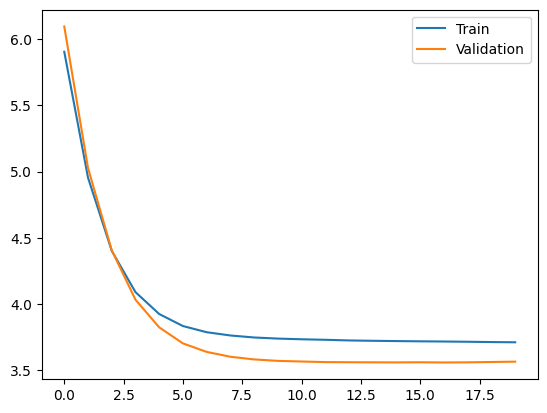

Validation Set:
  RMSE: 3.56328, MAE: 1.99268, R2/NSE: 0.74940, Loss SD: 3.56326
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_best/xgboost_best_model.pkl.


In [41]:
exp_dir = model_dir + os.sep + f"xgboost_best" 
if not (os.path.exists(exp_dir)):
    os.makedirs(exp_dir)
print(f"Experiment logs saved to {exp_dir}.")

# Define model
best_params = {}
best_params['n_estimators'] = 20
best_params['max_depth'] = 5
model = XGBRegressor(**best_params, random_state=42,
                     tree_method="approx", enable_categorical=True,
                     importance_type='gain',
                     n_jobs=-1, verbosity=0)

# fit model
evalset = [(train.X, train.y), (val.X, val.y)]
model.fit(train.X, train.y, eval_set=evalset)

# plot learning curves
results = model.evals_result()
plt.plot(results['validation_0']['rmse'], label='Train')
plt.plot(results['validation_1']['rmse'], label='Validation')
plt.legend()
plt.show()

print("Validation Set:")
model_eval(model, val.X, val.y)

# Save models
filesname = f"xgboost_best_model.pkl"
pickle.dump(model, open( exp_dir + os.sep + filesname, 'wb'))
print(f"  save model to {exp_dir + os.sep + filesname}.")

Experiment logs saved to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_best.
[0]	validation_0-rmse:6.36721	validation_1-rmse:6.61075
[1]	validation_0-rmse:5.55770	validation_1-rmse:5.73268
[2]	validation_0-rmse:4.96682	validation_1-rmse:5.09091
[3]	validation_0-rmse:4.54695	validation_1-rmse:4.62908
[4]	validation_0-rmse:4.25461	validation_1-rmse:4.29987
[5]	validation_0-rmse:4.05484	validation_1-rmse:4.07200
[6]	validation_0-rmse:3.91831	validation_1-rmse:3.91906
[7]	validation_0-rmse:3.82720	validation_1-rmse:3.81295
[8]	validation_0-rmse:3.76537	validation_1-rmse:3.74523
[9]	validation_0-rmse:3.72408	validation_1-rmse:3.69940
[10]	validation_0-rmse:3.69497	validation_1-rmse:3.66720
[11]	validation_0-rmse:3.67528	validation_1-rmse:3.64662
[12]	validation_0-rmse:3.66088	validation_1-rmse:3.63343
[13]	validation_0-rmse:3.65040	validation_1-rmse:3.62580
[14]	validation_0-rmse:3.64234	validation_1-rmse:3.62021
[15]	validation_0-rmse:3.63288	validation_1-rmse:3.61771
[16]	validat

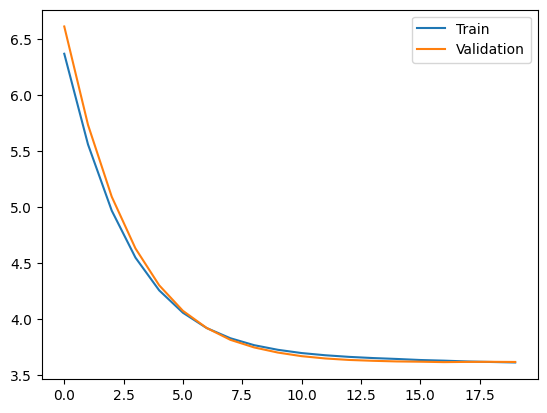

Validation Set:
  RMSE: 3.61547, MAE: 2.01939, R2/NSE: 0.74200, Loss SD: 3.61545
  save model to /root/co2-flux-hourly-gpp-modeling/data/models/xgboost_best/xgboost_best_model.pkl.


In [46]:
exp_dir = model_dir + os.sep + f"xgboost_best" 
if not (os.path.exists(exp_dir)):
    os.makedirs(exp_dir)
print(f"Experiment logs saved to {exp_dir}.")

# Define model
best_params = {}
best_params['n_estimators'] = 20
best_params['max_depth'] = 9
best_params['eta'] = 0.2
model = XGBRegressor(**best_params, random_state=42,
                     tree_method="approx", enable_categorical=True,
                     importance_type='gain',
                     n_jobs=-1, verbosity=0)

# fit model
evalset = [(train.X, train.y), (val.X, val.y)]
model.fit(train.X, train.y, eval_set=evalset)

# plot learning curves
results = model.evals_result()
plt.plot(results['validation_0']['rmse'], label='Train')
plt.plot(results['validation_1']['rmse'], label='Validation')
plt.legend()
plt.show()

print("Validation Set:")
model_eval(model, val.X, val.y)

# Save models
filesname = f"xgboost_best_model.pkl"
pickle.dump(model, open( exp_dir + os.sep + filesname, 'wb'))
print(f"  save model to {exp_dir + os.sep + filesname}.")

## Evaluate RFR on Val & Test Set

In [47]:
# Evaluate on Test
print("Test Set:")
model_eval(model, test.X, test.y)

Test Set:
  RMSE: 3.61022, MAE: 1.87034, R2/NSE: 0.67660, Loss SD: 3.60978
